# Custom modules

In [1]:
import os
import sys
sys.path.insert(1, '/home/mauricio/code/mcr/')

from mcr.ml.model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split, sample_report, split_report, sample_split_report
from mcr.ml import get_dummies_indices, reverse_dummies
from mcr.util import size, glimpse

# Standard data science modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')

# Loading data

Sign up for an account on [DrivenData](http://www.drivendata.org/)  
Join the [Box-plots for education competition](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/)  
Download the competition datasets named `TrainingData.csv` and `TestData.csv`

In [3]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

# Shuffling data

In machine learning theory, i.i.d. assumption is often made for training datasets to imply that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

To ensure observations are independent and don't follow any predefined sequence, the dataset is shuffled.

That's important when using the class `sklearn.model_selection.GridSearchCV` with k-fold cross-validation which doesn't resample the dataset as per the underlying class `sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)` doesn't shuffle data by default and that could lead to biased folds.

In [4]:
#df = df.sample(frac=1, replace=False, random_state=1)

# Encoding labels as category types

In [5]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
FEATURES = [feature for feature in df.columns if feature not in LABELS]
print('Memory before enconding: {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after enconding : {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))

Memory before enconding: 79.4 MiB (548.5 MiB deep)
Memory after enconding : 55.4 MiB (313.0 MiB deep)


# Converting labels in dummy variables

In [6]:
# Converting labels in dummy variables
y = pd.get_dummies(df[LABELS], prefix_sep='__')
y.info(memory_usage='deep')
y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 42.8 MB


,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
364634,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109283,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
102430,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
413949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
433672,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


# Test 0: trying to stratify split using sklearn's train_test_split()

In [8]:
# from sklearn.model_selection import train_test_split
# try:
#     X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = 0.5, random_state=1, stratify=y)
# except ValueError as err:
#     print('ValueError:', err)

As pointed out in **_Groups of labels with less than 2 samples (unstratifiable)_**, the y population has class groups with less than 2 observations, thefore, the standard sklearn's `train_test_split()` won't work because of those cases.

# Test 1: Imbalanced 50/50 split using sklearn's train_test_split(stratify=None)

Training size: 200138 (min_count: 14). Testing size: 200139 (min_count: 15)
Train ratio: 0.605313914702197
Test ratio : 0.6118644231571385


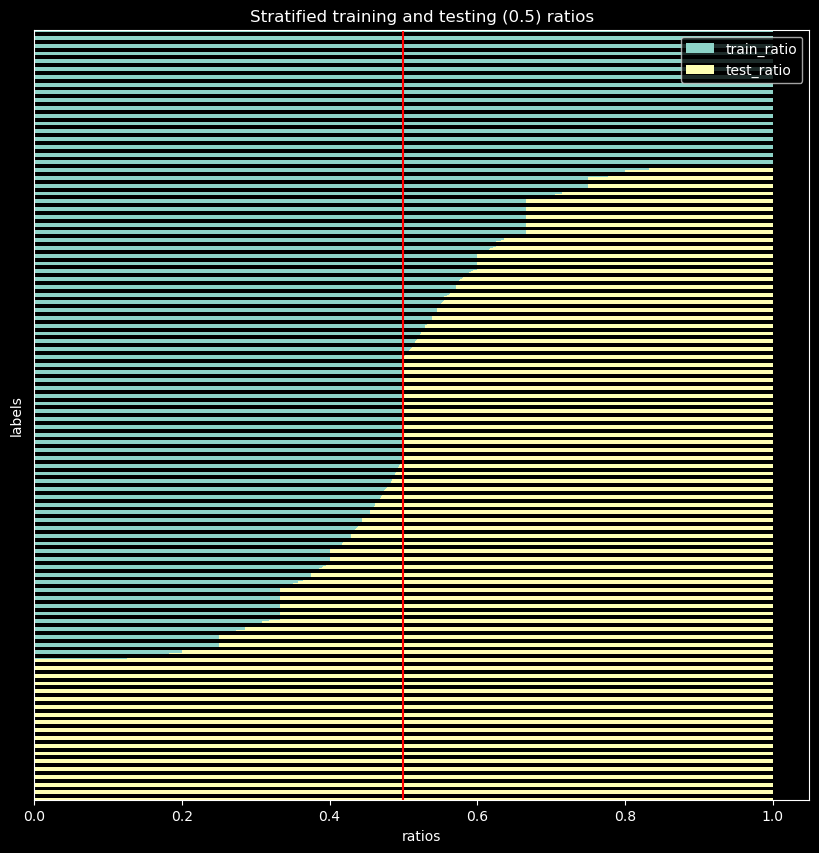

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = .5, random_state=1, stratify=None)
print(f'Training size: {X_train.shape[0]} (min_count: {y_train.sum().min()}). Testing size: {X_test.shape[0]} (min_count: {y_test.sum().min()})')
print(f'Train ratio: {(y_train.value_counts() / y.value_counts()).mean()}')
print(f'Test ratio : {(y_test.value_counts() / y.value_counts()).mean()}')
_ = split_report(y, y_train, y_test, figsize=(10,10))

# Test 2: stratifying 0.5 sample using multilabel_sample_dataframe()

In [77]:
for min_count in range(0,30):
    sampling = multilabel_sample_dataframe(df, y, size=0.5, min_count=min_count, seed=1)
    dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
    print(f'min_count given: {min_count} min_count taken: {dummy_labels.sum().min()} sample ratio: {(dummy_labels.value_counts() / y.value_counts()).mean()}')
# _ = sample_report(y, dummy_labels, figsize=(10,10))

min_count given: 0 min_count taken: 12 sample ratio: 0.6072375572442041
min_count given: 1 min_count taken: 16 sample ratio: 0.6138027727941249
min_count given: 2 min_count taken: 13 sample ratio: 0.6113674512226885
min_count given: 3 min_count taken: 17 sample ratio: 0.6129798763343044
min_count given: 4 min_count taken: 19 sample ratio: 0.6124721206075043
min_count given: 5 min_count taken: 18 sample ratio: 0.6116064363434706
min_count given: 6 min_count taken: 18 sample ratio: 0.6122606533451785
min_count given: 7 min_count taken: 14 sample ratio: 0.6088861542562353
min_count given: 8 min_count taken: 20 sample ratio: 0.6104340127432644
min_count given: 9 min_count taken: 25 sample ratio: 0.6098725917886925
min_count given: 10 min_count taken: 22 sample ratio: 0.6168670587717345
min_count given: 11 min_count taken: 21 sample ratio: 0.6168626174734579
min_count given: 12 min_count taken: 21 sample ratio: 0.611005531395129
min_count given: 13 min_count taken: 24 sample ratio: 0.610139

# Test 3: Stratifying 50/50 split using multi_train_test_split()

In [82]:
for min_count in range(0,30):
    X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], y, size=0.5, min_count=min_count, seed=1)
    print(f'min_count given: {min_count} train min_count: {y_train.sum().min()} test min_count: {y_test.sum().min()}', end=' ')
    print(f'train ratio: {(y_train.value_counts() / y.value_counts()).mean()} test ratio : {(y_test.value_counts() / y.value_counts()).mean()}', end=' ')
    print(f'difference: {(y_train.value_counts() / y.value_counts()).mean() - (y_test.value_counts() / y.value_counts()).mean()}')
# _= split_report(y, y_train, y_test, figsize=(10,10))

min_count given: 0 train min_count: 17 test min_count: 12 train ratio: 0.6123687900873017 test ratio : 0.6072375572442041 difference: 0.005131232843097577
min_count given: 1 train min_count: 13 test min_count: 16 train ratio: 0.6077455208819861 test ratio : 0.6138027727941249 difference: -0.006057251912138795
min_count given: 2 train min_count: 16 test min_count: 13 train ratio: 0.6071922307864619 test ratio : 0.6113674512226885 difference: -0.004175220436226645
min_count given: 3 train min_count: 12 test min_count: 17 train ratio: 0.6021737020495818 test ratio : 0.6129798763343044 difference: -0.010806174284722636
min_count given: 4 train min_count: 10 test min_count: 19 train ratio: 0.6085244606070431 test ratio : 0.6124721206075043 difference: -0.003947660000461206
min_count given: 5 train min_count: 11 test min_count: 18 train ratio: 0.6084340017059515 test ratio : 0.6116064363434706 difference: -0.0031724346375190393
min_count given: 6 train min_count: 11 test min_count: 18 train 

# Test 4: Stratifying 80/20 split of a stratified 0.7 sample using multi_train_test_split()

## Stratifying 0.7 sample

In [83]:
for min_count in range(0,30):
    sampling = multilabel_sample_dataframe(df, y, size=0.7, min_count=min_count, seed=1)
    dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
    print(f'min_count given: {min_count} min_count taken: {dummy_labels.sum().min()} sample ratio: {(dummy_labels.value_counts() / y.value_counts()).mean()}')
# _ = sample_report(y, dummy_labels, figsize=(10,10))

min_count given: 0 min_count taken: 18 sample ratio: 0.7696485333319797
min_count given: 1 min_count taken: 21 sample ratio: 0.7756801869918674
min_count given: 2 min_count taken: 18 sample ratio: 0.7728726007345827
min_count given: 3 min_count taken: 22 sample ratio: 0.7710488025463086
min_count given: 4 min_count taken: 24 sample ratio: 0.775150790291482
min_count given: 5 min_count taken: 24 sample ratio: 0.7718317282716475
min_count given: 6 min_count taken: 24 sample ratio: 0.7713355280411031
min_count given: 7 min_count taken: 22 sample ratio: 0.7697613175835779
min_count given: 8 min_count taken: 25 sample ratio: 0.7734969987781444
min_count given: 9 min_count taken: 25 sample ratio: 0.7725161064586407
min_count given: 10 min_count taken: 22 sample ratio: 0.7728179013798997
min_count given: 11 min_count taken: 24 sample ratio: 0.7767316222053126
min_count given: 12 min_count taken: 25 sample ratio: 0.7703721071923453
min_count given: 13 min_count taken: 27 sample ratio: 0.772982

## Stratifying 80/20 split of the 0.7 stratified sample

In [84]:
sampling = multilabel_sample_dataframe(df, y, size=0.7, min_count=25, seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
for min_count in range(0,30):
    X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels, size=0.2, min_count=min_count, seed=1)
    print(f'min_count given: {min_count} train min_count: {y_train.sum().min()} test min_count: {y_test.sum().min()}', end=' ')
    print(f'train ratio: {(y_train.value_counts() / y.value_counts()).mean()} test ratio : {(y_test.value_counts() / y.value_counts()).mean()}', end=' ')
    print(f'difference: {(y_train.value_counts() / y.value_counts()).mean() - (y_test.value_counts() / y.value_counts()).mean()}')    
#_ = sample_split_report(y, dummy_labels, y_train, y_test, figsize=(10,10))

min_count given: 0 train min_count: 20 test min_count: 5 train ratio: 0.6617828350329235 test ratio : 0.27218419632105284 difference: 0.3895986387118706
min_count given: 1 train min_count: 22 test min_count: 7 train ratio: 0.667185542300671 test ratio : 0.267754253169992 difference: 0.39943128913067893
min_count given: 2 train min_count: 18 test min_count: 11 train ratio: 0.6626364418918598 test ratio : 0.2769126808187563 difference: 0.38572376107310347
min_count given: 3 train min_count: 23 test min_count: 6 train ratio: 0.6650922646100611 test ratio : 0.26998205314567975 difference: 0.39511021146438136
min_count given: 4 train min_count: 20 test min_count: 9 train ratio: 0.6658103737246636 test ratio : 0.27038079233593587 difference: 0.3954295813887277
min_count given: 5 train min_count: 21 test min_count: 8 train ratio: 0.6635078079005058 test ratio : 0.2694075917234136 difference: 0.3941002161770922
min_count given: 6 train min_count: 20 test min_count: 9 train ratio: 0.66103657400

Here we see that some testing labels are missing after splitting.  
It's required to simultaneously optimize the `size` and `min_count` parameters on either `multilabel_sample_dataframe` and `multilabel_train_test_split`, thus, balancing the stratification the best possible to achieve the best ratio.

# Optimize sampling and splitting parameters

Run the script `optimize-sample-split.py` to prepare data for analysis

In [18]:
# ! python optimize-sample-split.py

In [19]:
import pickle
if not os.path.isfile('/data/drivendata/optimize-sample-split.pkl'):
    print('Please run the optimize-sample-split.py')
else:
    with open('/data/drivendata/optimize-sample-split.pkl', 'rb') as f:
        results = pickle.load(f)
        display(glimpse(results))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100799 entries, 0 to 100798
Columns: 10 entries, sample_size to test_ratio
dtypes: float64(5), object(5)
memory usage: 21.0 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,sample_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
1,sample_min_count,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
2,sample_ratio,100799,0.0,float64,541,"[0.06675592536155764, 0.07295573178258284, 0.0..."
3,sample_size,100799,0.0,float64,19,"[0.01, 0.01999999999999999, 0.03, 0.0399999999..."
4,test_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
5,test_min_count,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
6,test_ratio,100799,0.0,float64,100538,"[0.024211710155202838, 0.027255346978995582, 0..."
7,test_size,100799,0.0,float64,9,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,..."
8,train_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
9,train_ratio,100799,0.0,float64,100538,"[0.016213462665645117, 0.017129853111320717, 0..."


## Metric

Best sample, train, test ratios

In [20]:
metrics = ['sample_size', 'sample_ratio', 'train_ratio', 'test_ratio']
display(results.sort_values(metrics, ascending=False).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics))
results.sort_values(metrics, ascending=False).tail(3).style.set_properties(**{'background-color': 'red'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
5133,1.000000,19,29,1.000000,0.100000,3,22,7,0.927843,0.217250
7023,1.000000,26,29,1.000000,0.100000,3,22,7,0.927512,0.215472
6212,1.000000,23,29,1.000000,0.100000,2,24,5,0.927289,0.214517


,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
97582,0.010000,0,0,0.066756,0.700000,0,0,0,0.036745,0.060474
97583,0.010000,0,0,0.066756,0.800000,0,0,0,0.035214,0.061512
97584,0.010000,0,0,0.066756,0.900000,0,0,0,0.017565,0.066583


# Best parameters selection

* To allow cross-validation of 5 folds the minimal class frequency must be 5 for the training set and 1 for the test set.

In [21]:
k = 5
k_fold_condition = (results.train_lessfreq >= k) & (results.test_lessfreq >= 1) #& (results.train_lessfreq >= results.test_lessfreq)

* For begining the model, the selection should be:
    * The smallest sample size (e.g. 0.1)
    * The smallest test size (e.g. 0.1)
    * The best train ratios
* For finishing the model, the parameter set should have:
    * The full dataset
    * The smallest test size (e.g. 0.1)
    * best train ratios

## For 1% sample

In [22]:
ascending = [True, False, False, False]
results[k_fold_condition].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
100459,0.010000,28,28,0.145545,0.100000,0,22,1,0.139017,0.068591
100461,0.010000,28,28,0.145545,0.100000,2,21,3,0.137327,0.074610
100460,0.010000,28,28,0.145545,0.100000,1,21,1,0.135156,0.093377


## 10% sample

In [23]:
results[k_fold_condition & (results.sample_size>=0.1)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
62946,0.100000,28,28,0.250124,0.100000,0,23,1,0.232157,0.092049
62947,0.100000,28,28,0.250124,0.100000,1,23,2,0.230817,0.089238
62949,0.100000,28,28,0.250124,0.100000,3,23,5,0.230547,0.095275


## 20% sample

In [24]:
results[k_fold_condition & (results.sample_size>=0.19)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
58365,0.200000,28,28,0.357271,0.100000,0,26,1,0.336651,0.095655
58366,0.200000,28,28,0.357271,0.100000,1,26,2,0.334249,0.099641
58367,0.200000,28,28,0.357271,0.100000,2,25,3,0.333678,0.106211


## 30% sample

In [25]:
results[k_fold_condition & (results.sample_size>=0.2)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
53391,0.300000,28,28,0.450148,0.100000,3,24,4,0.420175,0.121831
53389,0.300000,28,28,0.450148,0.100000,1,27,1,0.419030,0.125206
53390,0.300000,28,28,0.450148,0.100000,2,21,4,0.418754,0.122319


## 50% sample

In [26]:
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) & (results.train_lessfreq > results.test_lessfreq) & (results.sample_size==0.5)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
42507,0.500000,29,29,0.620021,0.100000,0,27,2,0.578020,0.144577
42510,0.500000,29,29,0.620021,0.100000,3,23,6,0.576383,0.157208
42509,0.500000,29,29,0.620021,0.100000,2,22,6,0.576330,0.153578


## 60% sample

In [27]:
results[k_fold_condition & (results.sample_size==0.6)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
34070,0.600000,20,26,0.699567,0.100000,5,18,8,0.648227,0.161996
34067,0.600000,20,26,0.699567,0.100000,2,23,3,0.647990,0.175253
34065,0.600000,20,26,0.699567,0.100000,0,25,1,0.647182,0.166185


## 80% sample

In [28]:
results[k_fold_condition & (results.sample_size>=0.8)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
21726,0.800000,25,29,0.854414,0.100000,0,28,1,0.793677,0.192264
21727,0.800000,25,29,0.854414,0.100000,1,24,5,0.792206,0.191422
21729,0.800000,25,29,0.854414,0.100000,3,25,4,0.792142,0.202101


## For finishing the model

In [29]:
ascending = [False, False, False, False]
results[k_fold_condition
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
5133,1.000000,19,29,1.000000,0.100000,3,22,7,0.927843,0.217250
7023,1.000000,26,29,1.000000,0.100000,3,22,7,0.927512,0.215472
6212,1.000000,23,29,1.000000,0.100000,2,24,5,0.927289,0.214517
